In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from category_encoders import BinaryEncoder
from joblib import dump, load
from scipy.stats import mode
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

## Data Preprocessing

In [4]:
training_data_path = '/home/ghost/Documents/Machine Learning Project 2023/Botnet/training_data.csv'
test_data_path = '/home/ghost/Documents/Machine Learning Project 2023/Botnet/test_data.csv'
training_data_targets_path = '/home/ghost/Documents/Machine Learning Project 2023/Botnet/training_data_targets.csv'

training_data = pd.read_csv(training_data_path)
test_data = pd.read_csv(test_data_path)
training_data_targets = pd.read_csv(training_data_targets_path, header=None, names=['Target'])

In [5]:
len(training_data)

158976

In [6]:
def imp_enco(file):    
    
    #file = file.drop(['DST_IP', 'SRC_IP'], axis=1)
    
    numeric_cols_with_nan_test = file.columns[file.isnull().any()].tolist()
    imputer_test = SimpleImputer(missing_values=np.nan, strategy='median')
    file[numeric_cols_with_nan_test] = imputer_test.fit_transform(file[numeric_cols_with_nan_test])

    # Binary encoding for object dtype features
    object_cols = file.select_dtypes(include=['object']).columns
    binary_encoder = BinaryEncoder(cols=object_cols)
    file = binary_encoder.fit_transform(file)
    
    bool_cols_test = file.select_dtypes(include=['bool']).columns
    label_encoder_test = LabelEncoder()

    for col in bool_cols_test:
        file[col] = label_encoder_test.fit_transform(file[col])


    scaler_test = StandardScaler()
    numerical_cols_test = file.select_dtypes(include=['number']).columns
    file[numerical_cols_test] = scaler_test.fit_transform(file[numerical_cols_test])
    
    return file

In [7]:
training_data = imp_enco(training_data)
test_data = imp_enco(test_data)

## Basic EDA

In [8]:
print('This is Training data \n', training_data)
print('This is Test Data \n', test_data)

This is Training data 
         Unnamed: 0.1  Unnamed: 0  DST_IP_0  DST_IP_1  DST_IP_2  DST_IP_3  \
0          -0.975391   -0.975391 -0.067732 -0.346374 -0.361776 -0.385578   
1          -0.376880   -0.376880 -0.067732 -0.346374 -0.361776 -0.385578   
2          -1.144933   -1.144933 -0.067732 -0.346374 -0.361776 -0.385578   
3          -0.494488   -0.494488 -0.067732 -0.346374 -0.361776 -0.385578   
4          -0.845133   -0.845133 -0.067732 -0.346374 -0.361776 -0.385578   
...              ...         ...       ...       ...       ...       ...   
158971      2.440748    2.440748 -0.067732 -0.346374 -0.361776 -0.385578   
158972      2.053362    2.053362 -0.067732 -0.346374 -0.361776 -0.385578   
158973     -0.607435   -0.607435 -0.067732 -0.346374 -0.361776 -0.385578   
158974     -0.656585   -0.656585 -0.067732 -0.346374 -0.361776 -0.385578   
158975     -1.200862   -1.200862 -0.067732 -0.346374 -0.361776 -0.385578   

        DST_IP_4  DST_IP_5  DST_IP_6  DST_IP_7  ...  SPECTRAL_K

In [9]:
training_data_targets.value_counts()

Target   
clear        149016
neris          5699
fast_flux      3930
qvod            257
rbot             50
donbot           24
dtype: int64

In [10]:
label_encoder = LabelEncoder()

# Encoding the target variable
training_data_targets_encoded = label_encoder.fit_transform(training_data_targets['Target'])

dump(label_encoder, 'target_label_encoder.joblib')
training_data_targets_encoded

array([0, 0, 3, ..., 0, 0, 0])

In [11]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(training_data)

In [12]:
tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
tsne_result = tsne.fit_transform(training_data)

In [13]:
pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
pca_df['Target'] = training_data_targets['Target']

tsne_df = pd.DataFrame(tsne_result, columns=['t-SNE1', 't-SNE2'])
tsne_df['Target'] = training_data_targets['Target']

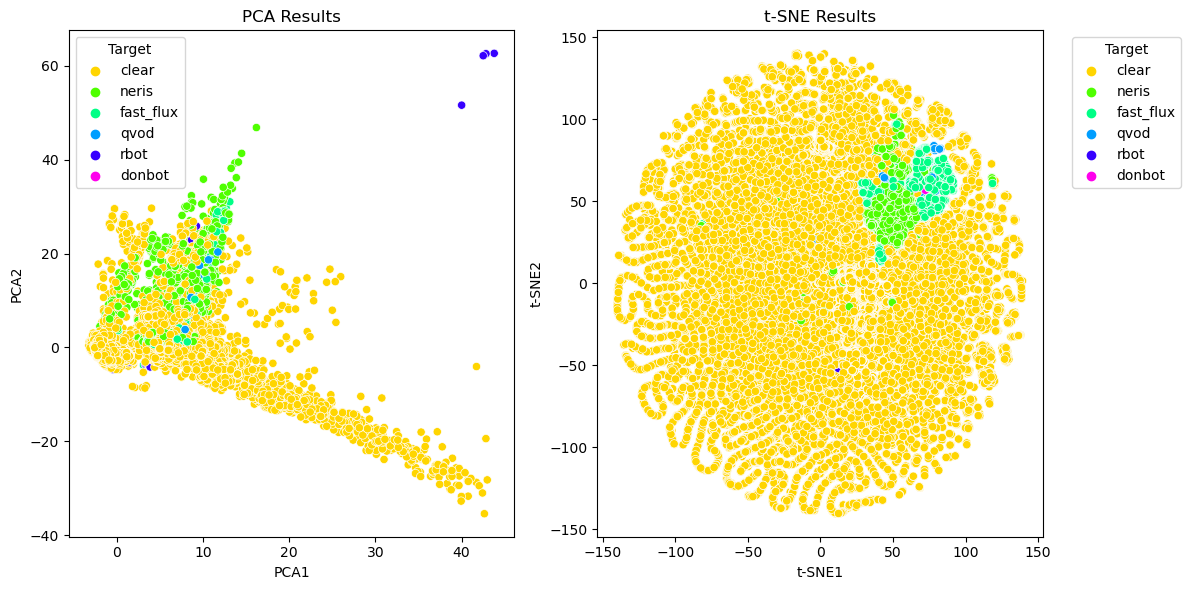

In [14]:
palette = sns.color_palette("hsv", len(pca_df['Target'].unique()))

# Plotting PCA results with a categorical color palette
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x='PCA1', y='PCA2', hue='Target', data=pca_df, palette=palette)
plt.title('PCA Results')

# Plotting t-SNE results with a categorical color palette
plt.subplot(1, 2, 2)
sns.scatterplot(x='t-SNE1', y='t-SNE2', hue='Target', data=tsne_df, palette=palette)
plt.title('t-SNE Results')

# Show the plot with a legend
plt.legend(title='Target', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Feature Selection

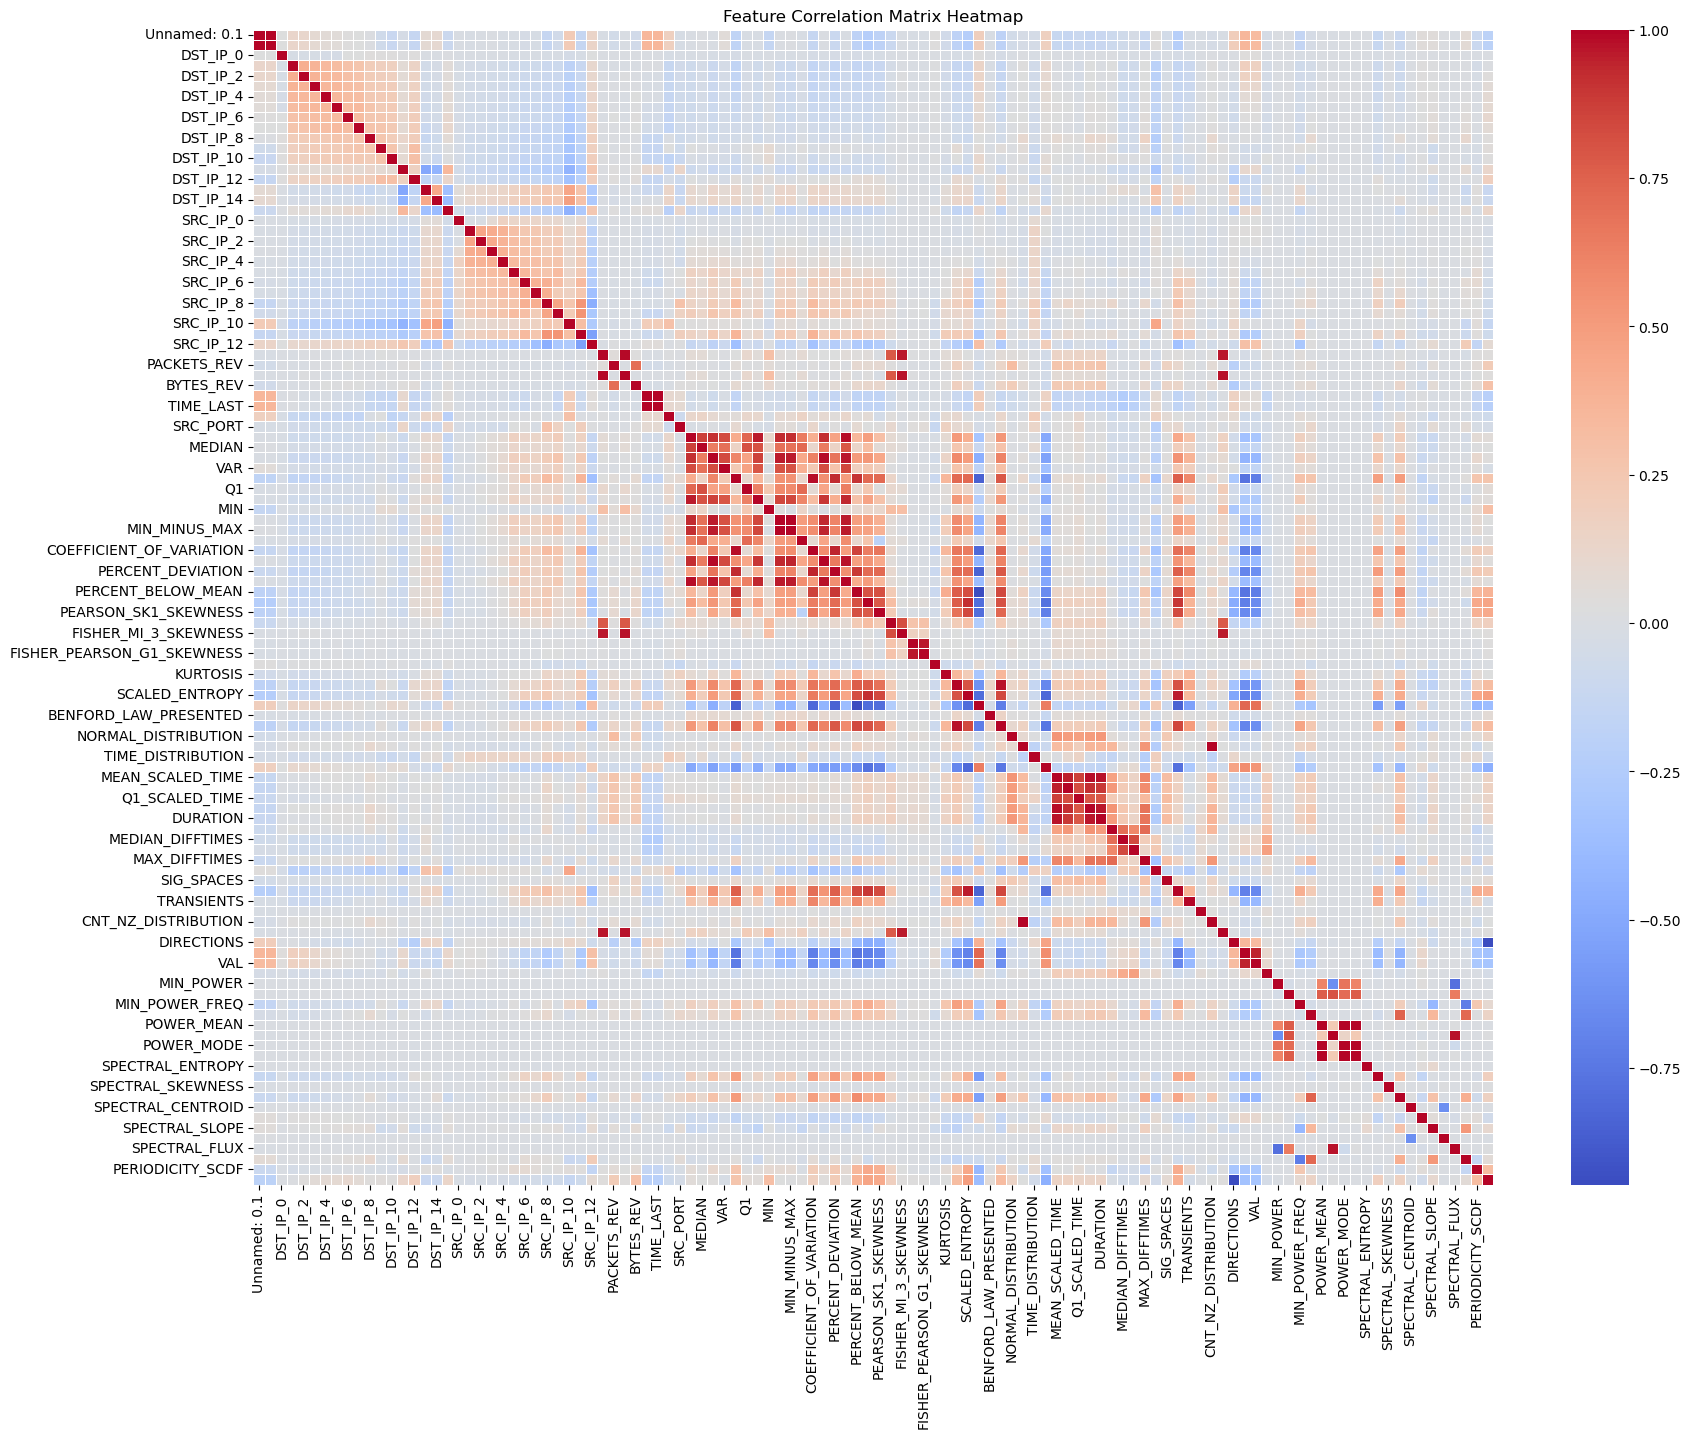

,Unnamed: 0.1,Unnamed: 0,DST_IP_0,DST_IP_1,DST_IP_2,DST_IP_3,DST_IP_4,DST_IP_5,DST_IP_6,DST_IP_7,...,SPECTRAL_SKEWNESS,SPECTRAL_ROLLOFF,SPECTRAL_CENTROID,SPECTRAL_SPREAD,SPECTRAL_SLOPE,SPECTRAL_CREST,SPECTRAL_FLUX,SPECTRAL_BANDWIDTH,PERIODICITY_SCDF,Target
Unnamed: 0.1,1.000000,1.000000,0.026122,0.119414,0.111851,0.082705,0.058507,0.054996,0.031496,0.021872,...,-0.007831,-0.107292,-0.002565,0.042187,0.048888,0.004436,-0.004068,0.071532,-0.105487,-0.191755
Unnamed: 0,1.000000,1.000000,0.026122,0.119414,0.111851,0.082705,0.058507,0.054996,0.031496,0.021872,...,-0.007831,-0.107292,-0.002565,0.042187,0.048888,0.004436,-0.004068,0.071532,-0.105487,-0.191755
DST_IP_0,0.026122,0.026122,1.000000,-0.023461,-0.024504,-0.026116,-0.027995,-0.029528,0.019431,0.026632,...,0.000421,-0.019432,-0.000859,0.006713,0.001953,0.000851,-0.000239,0.000512,-0.007165,-0.001699
DST_IP_1,0.119414,0.119414,-0.023461,1.000000,0.401690,0.376084,0.343755,0.319982,0.282633,0.264078,...,0.001305,-0.091281,-0.001028,0.032000,0.013538,0.001848,-0.001225,0.005155,-0.035354,0.004602
DST_IP_2,0.111851,0.111851,-0.024504,0.401690,1.000000,0.378271,0.349496,0.332174,0.294133,0.274804,...,0.002353,-0.084670,-0.000341,0.030187,0.019274,0.001409,-0.001279,0.004822,-0.021496,0.034828


In [15]:
training_data_combined = training_data.copy()
training_data_combined['Target'] = training_data_targets_encoded

# Compute the correlation matrix
correlation_matrix = training_data_combined.corr()

plt.figure(figsize=(20, 15))

# Create the heatmap
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, linewidths=.5)

# Show the heatmap
plt.title('Feature Correlation Matrix Heatmap')
plt.show()
correlation_matrix.head()

In [16]:
correlations_with_target = training_data_combined.corr()['Target'].abs()

In [17]:
high_corr_columns = correlations_with_target[correlations_with_target > 0.32].index

# Print the selected features
print("Features highly correlated with the target:")
print([col for col in high_corr_columns if col != 'Target'])

Features highly correlated with the target:
['PERCENT_BELOW_MEAN', 'PERCENT_ABOVE_MEAN', 'PEARSON_SK1_SKEWNESS', 'SCALED_ENTROPY', 'HURST_EXPONENT', 'P_BENFORD', 'AREA_VALUES_DISTRIBUTION', 'SWITCHING_METRIC', 'DIRECTIONS', 'PERIODICITY']


### Feature Selection - using Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier

X = training_data  # Features
y = training_data_targets['Target']  # Target variable

# Train a model to assess feature importances
model = RandomForestClassifier(n_jobs=-1)
model.fit(X, y)

RandomForestClassifier(n_jobs=-1)

In [19]:
importances = pd.DataFrame({'feature':X.columns,'importance':np.round(model.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

importances = importances.head(15)
print(importances)

                          importance
feature                             
PACKETS_REV                    0.102
BYTES_REV                      0.089
DIRECTIONS                     0.087
Q1                             0.070
TIME_LAST                      0.068
MIN                            0.053
DST_PORT                       0.039
TIME_FIRST                     0.038
MEDIAN                         0.032
MODE                           0.032
PERCENT_ABOVE_MEAN             0.025
AREA_VALUES_DISTRIBUTION       0.019
SCALED_ENTROPY                 0.016
FISHER_MI_3_SKEWNESS           0.016
PEARSON_SK2_SKEWNESS           0.016


In [20]:
selector = RFE(model, n_features_to_select=10, step=2)
selector = selector.fit(X, y)

ranking = pd.DataFrame({'feature':X.columns, 'ranking':selector.ranking_})

selected_features_RFE = ranking[ranking['ranking'] == 1]['feature'].values

In [21]:
selected_features_RFE

array(['PACKETS_REV', 'BYTES_REV', 'TIME_FIRST', 'TIME_LAST', 'DST_PORT',
       'SRC_PORT', 'Q1', 'MIN', 'MODE', 'DIRECTIONS'], dtype=object)

## Data Modeling

In [22]:
X_train, X_test, y_train, y_test = train_test_split(training_data[selected_features_RFE] , training_data_targets_encoded, test_size=0.3, random_state=42)

In [23]:
smote = SMOTE()
X_sm, y_sm = smote.fit_resample(X_train, y_train)

In [24]:
majority_class_indices = np.where(y_sm == 0)[0]
undersample_size = len(majority_class_indices) // 2

In [25]:
num_models = 5  
predictions = []

for i in range(num_models):
    np.random.shuffle(majority_class_indices)
    undersampled_majority_indices = majority_class_indices[:undersample_size]

    balanced_indices = np.concatenate([np.where(y_sm != 0)[0], undersampled_majority_indices])
    X_balanced = X_sm.iloc[balanced_indices]  
    y_balanced = y_sm[balanced_indices]        

    model = RandomForestClassifier(random_state=i, n_jobs=-1)
    model.fit(X_balanced, y_balanced)
    dump(model, f'random_forest_model_{i}.joblib')

In [26]:
for i in range(num_models):
    # Load the trained model
    model = load(f'random_forest_model_{i}.joblib')
    
    # Generate predictions
    predictions.append(model.predict(X_test))

predictions_array = np.array(predictions)

final_predictions = mode(predictions_array, axis=0).mode.squeeze()

decoded_predictions = label_encoder.inverse_transform(final_predictions)

print("Shape of final_predictions:", final_predictions.shape)
output = pd.DataFrame({'Prediction': decoded_predictions})
output.to_csv('ensemble_predictions.csv', index=False)

/tmp/ipykernel_23635/80531281.py:10: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_predictions = mode(predictions_array, axis=0).mode.squeeze()


Shape of final_predictions: (47693,)


In [27]:
decoded_y_test = label_encoder.inverse_transform(y_test)
cm = confusion_matrix(decoded_y_test, decoded_predictions)
report = classification_report(decoded_y_test, decoded_predictions)

In [28]:
class_names = label_encoder.classes_

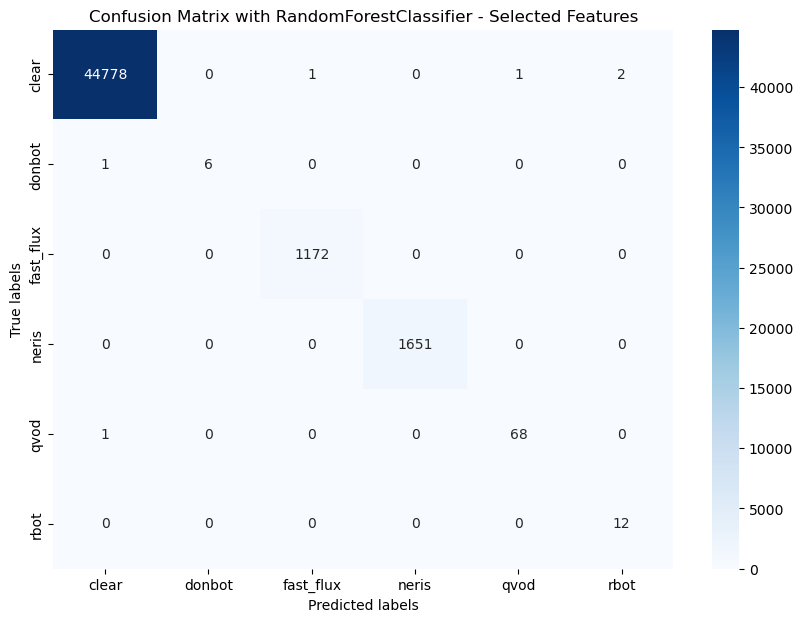

Classification Report with RandomForestClassifier - Selected Features:
               precision    recall  f1-score   support

       clear       1.00      1.00      1.00     44782
      donbot       1.00      0.86      0.92         7
   fast_flux       1.00      1.00      1.00      1172
       neris       1.00      1.00      1.00      1651
        qvod       0.99      0.99      0.99        69
        rbot       0.86      1.00      0.92        12

    accuracy                           1.00     47693
   macro avg       0.97      0.97      0.97     47693
weighted avg       1.00      1.00      1.00     47693



In [29]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix with RandomForestClassifier - Selected Features')
plt.show()

# Compute and print the classification report
report = classification_report(decoded_y_test, decoded_predictions)
print("Classification Report with RandomForestClassifier - Selected Features:\n", report)

In [30]:
average_f1_macro = f1_score(decoded_y_test, decoded_predictions, average='macro')
print(average_f1_macro)

0.971861276766742


In [31]:
average_f1_micro = f1_score(decoded_y_test, decoded_predictions, average='micro')
average_f1_micro

0.9998741953745832

In [35]:
new_data_selected = test_data[selected_features_RFE]  

# an empty list to store predictions from each model
new_data_predictions = []

for i in range(num_models):
    model = load(f'random_forest_model_{i}.joblib')
    new_data_predictions.append(model.predict(new_data_selected))

# Convert predictions to a NumPy array and perform majority voting
predictions_array = np.array(new_data_predictions)
final_new_data_predictions = mode(predictions_array, axis=0).mode.squeeze()

# Decode predictions if necessary
decoded_new_data_predictions = label_encoder.inverse_transform(final_new_data_predictions)

# Save or output the final predictions
output_test_data = pd.DataFrame({'Prediction': decoded_new_data_predictions})
output_test_data.to_csv('ensemble_predictions.csv', index=False, header=False)

/tmp/ipykernel_23635/447699574.py:12: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_new_data_predictions = mode(predictions_array, axis=0).mode.squeeze()


In [33]:
output_test_data

,0
0,clear
1,clear
2,clear
3,clear
4,clear
...,...
17659,clear
17660,clear
17661,clear
17662,clear


### KNN

In [25]:
num_models = 5  # Number of models
predictions = []

for i in range(num_models):
    # Undersample majority class for each model
    np.random.shuffle(majority_class_indices)
    undersampled_majority_indices = majority_class_indices[:undersample_size]

    # Combine with minority class indices
    balanced_indices = np.concatenate([np.where(y_sm != 0)[0], undersampled_majority_indices])
    X_balanced = X_sm.iloc[balanced_indices]  # Use this if X_sm is a DataFrame
    y_balanced = y_sm[balanced_indices]        # Use this for NumPy array


    # Train model
    model = KNeighborsClassifier(n_jobs=-1)
    model.fit(X_balanced, y_balanced)
    predictions.append(model.predict(X_test))


In [26]:
predictions_array = np.array(predictions)

final_predictions = mode(predictions_array, axis=0).mode.squeeze()

print("Shape of final_predictions:", final_predictions.shape)

Shape of final_predictions: (47693,)


In [27]:
decoded_predictions = label_encoder.inverse_transform(final_predictions)
decoded_y_test = label_encoder.inverse_transform(y_test)

# Compute the confusion matrix and classification report with decoded labels
cm = confusion_matrix(decoded_y_test, decoded_predictions)
report = classification_report(decoded_y_test, decoded_predictions)

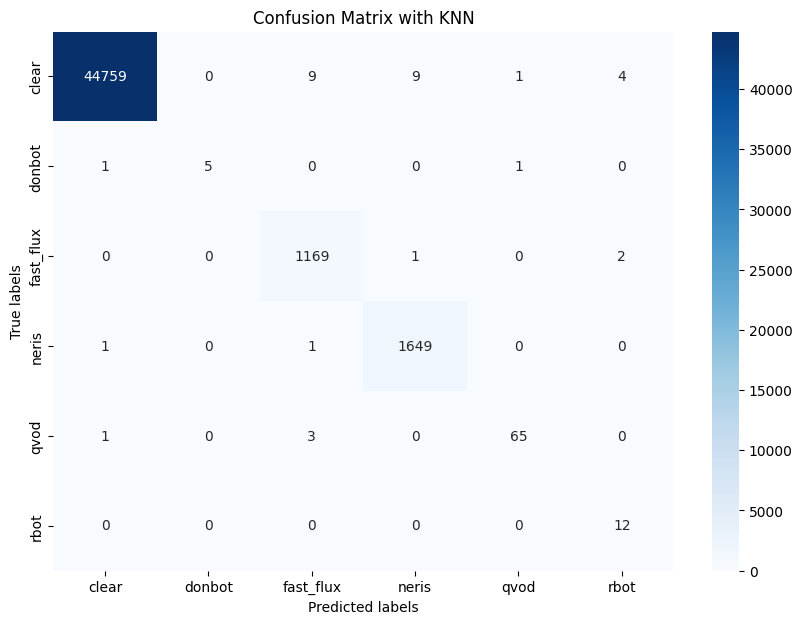

Classification Report with KNN:
               precision    recall  f1-score   support

       clear       1.00      1.00      1.00     44782
      donbot       1.00      0.71      0.83         7
   fast_flux       0.99      1.00      0.99      1172
       neris       0.99      1.00      1.00      1651
        qvod       0.97      0.94      0.96        69
        rbot       0.67      1.00      0.80        12

    accuracy                           1.00     47693
   macro avg       0.94      0.94      0.93     47693
weighted avg       1.00      1.00      1.00     47693



In [28]:
class_names = label_encoder.classes_
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix with KNN')
plt.show()

# Compute and print the classification report
report = classification_report(decoded_y_test, decoded_predictions)
print("Classification Report with KNN:\n", report)

### SVC + GridSearchCV

In [29]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Replace 'training_data' and 'selected_features_RFE' with your actual dataset and selected features
# Replace 'training_data_targets_encoded' with your actual target variable
# For demonstration, let's assume 'training_data' is your DataFrame and 'selected_features_RFE' is a list of selected feature names

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    training_data[selected_features_RFE], 
    training_data_targets_encoded, 
    test_size=0.2, 
    random_state=42
)

# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

# Instantiate a Support Vector Classifier
svc = SVC()

# Instantiate GridSearchCV with the SVC model and the parameter grid
grid_search = GridSearchCV(svc, param_grid, refit=True, verbose=3, n_jobs=-1)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best SVC model
best_params = grid_search.best_params_
best_svc = grid_search.best_estimator_

# Predict on the test data using the best model
y_pred = best_svc.predict(X_test)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.997 total time=  41.3s
[CV 1/5] END .....C=1, gamma=0.1, kernel=linear;, score=0.997 total time= 3.8min
[CV 5/5] END ......C=10, gamma=1, kernel=linear;, score=0.998 total time= 1.4min
[CV 2/5] END .......C=10, gamma=0.1, kernel=rbf;, score=1.000 total time=   7.0s
[CV 4/5] END .......C=10, gamma=0.1, kernel=rbf;, score=1.000 total time=   6.8s
[CV 1/5] END ....C=10, gamma=0.1, kernel=linear;, score=0.998 total time= 5.3min
[CV 5/5] END .....C=100, gamma=1, kernel=linear;, score=0.998 total time= 8.3min
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.997 total time=  41.2s
[CV 5/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.999 total time=  13.5s
[CV 2/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.997 total time=   8.8s
[CV 3/5] END ....C=1, gamma=0.01, kernel=linear;, score=0.998 total time=   7.2s
[CV 3/5] END ......C=1, gamma=0.001, kernel=rbf

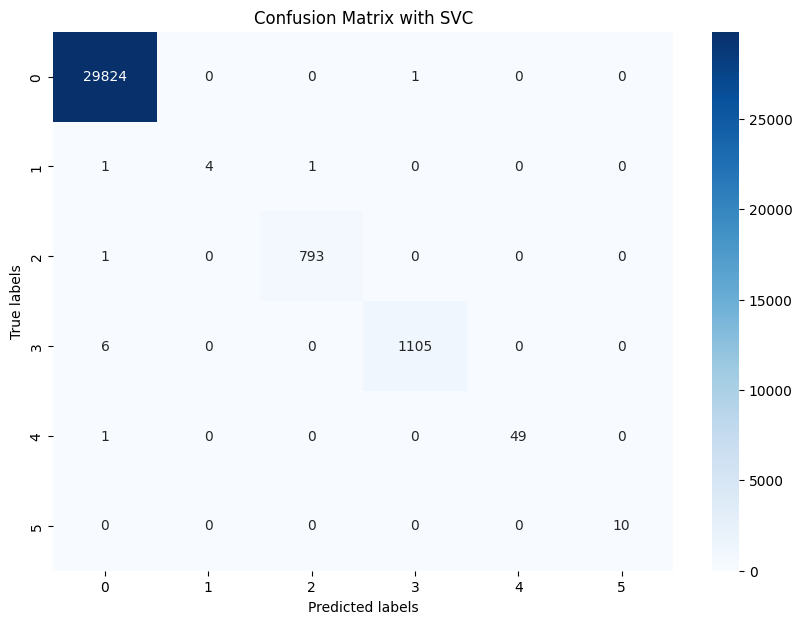

Classification Report with SVC:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     29825
           1       1.00      0.67      0.80         6
           2       1.00      1.00      1.00       794
           3       1.00      0.99      1.00      1111
           4       1.00      0.98      0.99        50
           5       1.00      1.00      1.00        10

    accuracy                           1.00     31796
   macro avg       1.00      0.94      0.96     31796
weighted avg       1.00      1.00      1.00     31796

Best parameters found by GridSearchCV: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
F1 Score: 0.9996473684247565


In [30]:
# Calculate the F1 score
f1 = f1_score(y_test, y_pred, average='weighted')  

# Compute the confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix with SVC')
plt.show()

# Print the classification report
print("Classification Report with SVC:\n", report)

# Print the best parameters
print(f"Best parameters found by GridSearchCV: {best_params}")

# Print the F1 score
print(f"F1 Score: {f1}")

## The End